In [33]:
import pandas as pd
import requests
import json
from tqdm import tqdm
import numpy as np
from datetime import datetime

CONNECTION_ON = False
MODEL = 'gpt-4o' #'gpt-3.5-turbo',

In [34]:
from typing import Optional


def prompt(input):
    if not CONNECTION_ON:
        raise Exception
    
    api_key = None
    api_url = 'https://api.openai.com/v1/chat/completions'

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}',
    }

    data = {
        'model': MODEL,
        'messages': [
            {'role': 'user', 'content': input},
        ],
        'max_tokens': 2000,
        'temperature': 0.5,
    }

    response = requests.post(api_url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        print(f"Error: {response.status_code}")
        return response.json()

def stripJSON(text: Optional[str], added_bracket = False, debug = False) -> Optional[dict]:
    if (text is None):
        return None
    
    #text = text.replace('\(', '(').replace('\)', ')') #Mistral likes to add escape sequences, for some unknown reason
    text = text.replace("```", "").replace('json', '')
    
    if (debug):
        print(text)
        try:
            json.loads(text)
        except Exception as e:
            print(e)

    # a very manual way of finding our JSON string within the output
    
    all_open_brackets = [i for i, ltr in enumerate(text) if ltr == '{']
    obj = None
    for start in all_open_brackets:
        balance_counter = 1
        for offset, chr in enumerate(text[start + 1:], start = 1):
            balance_counter += (1 if chr == '{' else -1 if chr == '}' else 0)
            if (balance_counter == 0):
                try:
                    obj = json.loads(text[start: start + offset + 1])
                except:
                    pass
                break
        if (obj is not None):
            break
        
    # sometimes we miss the first or last bracket (dumb LLM), so we add it manually.
    if not added_bracket:
        return (stripJSON('{' + text, added_bracket = True) or stripJSON(text + '}', added_bracket = True))
        
    return obj


def update_labels(path, 
                  column = 'alex2',
                  ground_truth_path = '/home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled.csv',
                  save = False):
    ground_df = pd.read_csv(ground_truth_path)
    to_update_df = pd.read_csv(path)
    
    updated = 0
    for idx in to_update_df.index:
        mask = ground_df['multisentence'] == to_update_df['multisentence'].loc[idx]
        assert(mask.sum() == 1)
        
        if to_update_df[column].loc[idx] != ground_df[column].loc[idx]:
            updated += 1
            to_update_df[column].loc[idx] = ground_df[column].loc[idx]
    
    print(f"Updated {updated} labels in {path}.")
    
    if (save):
        print(f"Saving to original path. ")
        to_update_df.to_csv(path, index = False)
    return to_update_df


In [97]:
questions = {
1: "The CITING sentences explicitly mention results from the CITED paper to support background claims.",
2: "The CITING sentences explicitly mention a techniques of the CITED paper in order to provide relevant context.",
3: "The CITING sentences mention performance results of the CITED paper to contextualize the CITED model's capabilities.",
4: "The CITING sentences mention deploying the CITED foundation model's encoder or decoder as part of their methodology.",
5: "The CITING sentences uses the CITED foundation model to create embeddings as part of their methodology.",
6: "The CITING sentences explicitly describe their methodology including fine-tuning or adjusting the parameter weights of the CITED foundation model.",
7: "The CITING sentences describe adopting the CITED foundation model's architecture as part of their model design.",
8: "The CITING sentences describe training a model using the CITED paper's dataset.",
9: "The CITING sentences mention using the CITED foundation model for feature extraction as part of their methodology.",
10: "The CITING sentences mention using the CITED foundation model as a classifier or detector as part of their methodology.",
11: "The CITING sentences describes deploying the CITED foundation model to generate data in the form of text/image/audio/video for later training of their model."}

questions_as_string = '\n'.join([f"{key}. {value}" for key, value in questions.items()])

MULTIPROMPT = ("""The following sentences are from an academic paper (the CITING paper) which references a pretrained machine learning model through citation (the CITED paper). The models are called foundation models, and they might be a language model, a vision model, or any other kind of large neural network. The CITED paper is highlighed using HTML tags as such: <cite> cited reference </cite>. All other citations can be ignored, as we only care about the cited reference with these tags.

We'd like to discern how the CITING paper makes use of the foundation model, as described within the sentences. Below are ten statements, which will be evaluated as either true or false. Only use the sentences provided to answer the questions about this particular paper's use of the foundation model, not other references. \n""" + questions_as_string + 


"""Please respond with the following information per question:
    (a) an explanation of the relevant information
    (b) if applicable, explain how you know this usage of the <cite> CITED </cited> foundation model is by the CITING paper rather than a different reference in the sentences (or say "didn't use").
    (c) The final True or False answer to the question.
Use this JSON format: {{"explanation_1": "Information relevant to the first question...", "confirmation_1": "True | False", "answer_1": "True | False", "explanation_2": "Information relevant to the second question..." , "confirmation_2": "True | False", "answer_2": "True | False", ... }}, classifying based on the following:\n\n{input}""" )


SINGLEPROMPT = ("""The following sentences are from an academic paper (the CITING paper) which references a pretrained machine learning model through citation (the CITED paper). The models are called foundation models, and they might be a language model, a vision model, or any other kind of large neural network. The CITED paper is highlighed using HTML tags as such: <cite> cited reference </cite>. All other citations can be ignored, as we only care about the cited reference with these tags.

We'd like to discern how the CITING paper makes use of the foundation model, as described within the sentences. Below are ten statements, which will be evaluated as either true or false.

{question}

Please response in this JSON format: {{"explanation": "True | False"}}, classifying based on the following:\n\n{input}""" )


sentences = 'these models take transformers (vaswani et al, 2017) as the backbone, and predict the next token based on previous tokens.1 prior to the widespread adoption of transformers, autoregressive language models were built on the backbones of n-grams (bickel et al, 2005; pauls and klein, 2011) and recurrent neural networks (mikolov et al, 2010), and have been applied to various nlg tasks such as summarization (nallapati et al, 2017) and dialogue generation (chen et al, 2017). footnote 1: another variant of language models predicts masked tokens in a corrupted sequence (devlin et al, 2019; <cite>liu et al, 2019</cite>; lan et al, 2019, _inter alia_). transformer-based llms have demonstrated exceptional performance across tasks, and have therefore shifted nlp from a paradigm centered on task-specific solutions to general-purpose pretraining (devlin et al, 2019; radford et al, 2019).'

print(MULTIPROMPT)

The following sentences are from an academic paper (the CITING paper) which references a pretrained machine learning model through citation (the CITED paper). The models are called foundation models, and they might be a language model, a vision model, or any other kind of large neural network. The CITED paper is highlighed using HTML tags as such: <cite> cited reference </cite>. All other citations can be ignored, as we only care about the cited reference with these tags.

We'd like to discern how the CITING paper makes use of the foundation model, as described within the sentences. Below are ten statements, which will be evaluated as either true or false. Only use the sentences provided to answer the questions about this particular paper's use of the foundation model, not other references. 
1. The CITING sentences explicitly mention results from the CITED paper to support background claims.
2. The CITING sentences explicitly mention a techniques of the CITED paper in order to provide 

In [4]:
urop_path = '/home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled'
df = pd.read_csv(urop_path + '.csv')



In [191]:
other_path = '/home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled_gpt4o_response_2024-06-21 09:38:45.344243.csv'

df = update_labels(other_path, save = True)

Updated 0 labels in /home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled_gpt4o_response_2024-06-21 09:38:45.344243.csv.
Saving to original path. 


In [5]:
results = []
for sentence in tqdm(df['multisentence']):
    #each_question = {}
    #for key, question in questions.items():
    #    each_question[str(key)] = stripJSON(prompt(SINGLEPROMPT.format(input = sentence, question = question))).get('explanation')
    results.append(prompt(MULTIPROMPT.format(input = sentence)))
df['mcllm_gpt_booleans'] = results
new_path = urop_path + f"_{MODEL}_response_{datetime.now()}.csv"
df.to_csv(new_path, index = False)

100%|██████████| 201/201 [37:49<00:00, 11.29s/it]


In [192]:
def get_truth(r):
    if isinstance(r, str):
        r = stripJSON(r)
        
    if r is None:
        return None
    

    for key, item in r.items():
        if key == 'error':
            return None
        r[key] = {'true': True, 'false': False, None: False}.get(item if not isinstance(item, str) else item.lower())
    
    uses = np.array([r.get(f"answer_{i}") for i in range(4, 7)] + [r.get(f"answer_{i}") for i in range(9, 12)] ).astype(bool).sum()
    background = np.array([r.get(f"answer_{i}") for i in range(1, 4)]).astype(bool).sum()
    not_uses = np.array([r.get(f"answer_{i}") for i in range(7, 9)]).astype(bool).sum()

    
    if background >= 2: # or not_uses > 0:
        return 'background'

    if uses > 0:
        return 'uses'
    
    if background:
        return 'background'

    return 'background'

df['mcllm_binary'] = df['mcllm_gpt_booleans'].apply(get_truth)

print(set(df['mcllm_binary']))

for idx, row in df.iterrows():
    if (row['mcllm_binary'] is None):
        print(row['multisentence'])
        print(row['mcllm_binary'])
        print(row['mcllm_gpt_booleans'])
        print("\n")
    else:
        pass

{None, 'background', 'uses'}
we report the setting with the best performance for each baseline. our implementation of per-token cql is identical to ilql with the only exception being that for per-token cql the loss function is defined as:

\[l_{q,v}(\theta)=\mathbf{e}_{\tau\sim d}\left[\sum_{i=0}^{t}(r(h_{i},a_{i})+ \gamma\max_{a_{t+1}\in\mathcal{a}}q_{\hat{\theta}}(h_{i+1},a_{t+1})-q_{\theta }(h_{i},a_{i}))^{2}\right]\]

our implementation of \(\psi\)-learning is adapted from jaques et al (jaques et al, 2020, 2017) for use on transformer language models (vaswani et al, 2017; <cite>radford et al, 2019</cite>) instead of rnns (gers et al, 2000). the architecture is identical to that of ilql, the main difference is in the loss function:

\[l_{q,v}(\theta)=\mathbf{e}_{\tau\sim d}\left[\sum_{i=0}^{t}l_{\delta}(\frac{ r(h_{i},a_{i})}{c}+\log(\pi_{\beta}(h_{i},a_{i}))+\gamma\log(\sum_{a_{t+1} \in\mathcal{a}}\exp q_{\hat{\theta}}(h_{i+1},a_{t+1}))-q_{\theta}(h_{i},a_{i }))\right]\]

where \(\

In [193]:
df['mcllm_binary'].isna().sum()

1

In [195]:
y_label, x_label = 'alex2', 'mcllm_binary'
df = df[~df[y_label].isna() & ~df[x_label].isna()]



#df['urop'] = df['urop'].apply(str.lower)
#df = df[df['urop'] != 'select']

"""df['mcllm_binary_stripped'] = df['mcllm_binary'].apply(lambda s: tuple(v.lstrip("('").rstrip("')") for v in s.split(","))[0])
df['mcllm_binary_stripped']
df = df[df['mcllm_binary_stripped'] != 'unclear']
x_label = 'mcllm_binary_stripped'"""

'df[\'mcllm_binary_stripped\'] = df[\'mcllm_binary\'].apply(lambda s: tuple(v.lstrip("(\'").rstrip("\')") for v in s.split(","))[0])\ndf[\'mcllm_binary_stripped\']\ndf = df[df[\'mcllm_binary_stripped\'] != \'unclear\']\nx_label = \'mcllm_binary_stripped\''

In [270]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

seed = 1
train_size = 150
true = np.random.RandomState(seed=seed).permutation(df[y_label])[:train_size]
pred = np.random.RandomState(seed=seed).permutation(df[x_label])[:train_size]


mapping = lambda s: {'background': 'context',
                     'future_work': 'context',
                    'differences': 'context',
                     'future work': 'context',
                     'motivation': 'context',
                     'similarities': 'context',
                     'extends': 'uses',
                     '*': 'context'
                     }.get(s) or s
true, pred = list(map(mapping, true)), list(map(mapping, pred))

cm = confusion_matrix(true, pred)

{'uses', 'context'} {'uses', 'context'}


Text(50.722222222222214, 0.5, 'alex2')

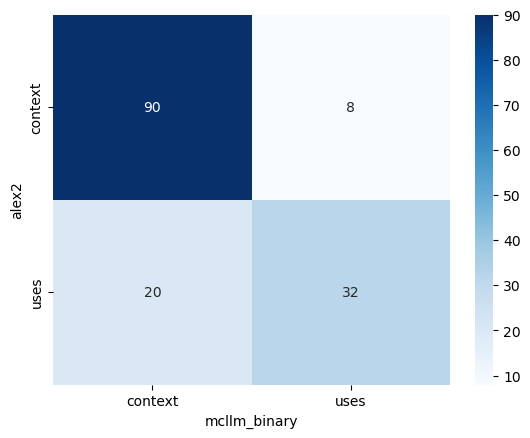

In [271]:
#assert(len(set(true)) == 3), set(true)
#assert(len(set(pred)) == 3), set(pred)
#labels = ['context', 'extends', 'uses']
print(set(true), set(pred))

labels = ['context', 'uses']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel(x_label)
plt.ylabel(y_label)

In [272]:
false_positives = (cm - cm * np.identity(len(labels))).sum(axis = 0)/cm.sum(axis = 0)
false_negatives = (cm - cm * np.identity(len(labels))).sum(axis = 1)/cm.sum(axis = 1)

print(false_positives)
print(false_negatives)

[0.18181818 0.2       ]
[0.08163265 0.38461538]


In [273]:
def get_examples(y_value, x_value):
    mask = (df[y_label].apply(mapping) == y_value) & (df[x_label].apply(mapping) == x_value) 
    return df[mask]

def format_as_questions(s):
    L = list(questions.items())
    L.reverse()
    for key, value in L:
        s = s.replace(f"answer_{key}", value)
    return s

idx = -1
samples = get_examples(y_value='uses', x_value = 'context')
print(len(samples))

26


In [279]:
idx += 1
index = samples.index[idx]
print(idx, index)
print(f"Drawing from {len(samples)} samples")
print(samples['modelKey'].iloc[idx])

print(samples['multisentence'].iloc[idx])
print(samples['mcllm_gpt_booleans'].iloc[idx])
print(samples[y_label].iloc[idx])
print(samples[x_label].iloc[idx])


4 93
Drawing from 26 samples
529_chinchilla
to prevent participants from intentionally or unintentionally selecting examples in a way that overfit to the quirks of a specific model series, we also ran evaluations on several private model series, to check that inverse scaling was also present on held-out models. private models were provided by anthropic (models trained in bai et al, 2022)2 and deepmind (gopher: rae et al, 2021, and chinchilla: <cite>hoffmann et al, 2022</cite>). for deepmind models, we report performance at each model size.
```json
{
    "explanation_1": "The sentence mentions results from the CITED paper by stating the performance of the DeepMind models (Gopher and Chinchilla) in the context of inverse scaling.",
    "confirmation_1": "True",
    "answer_1": "True",
    
    "explanation_2": "The sentence does not explicitly mention any techniques from the CITED paper. It only mentions the performance results of the models.",
    "confirmation_2": "True",
    "answer_2

In [275]:
og_path = '/home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled.csv'
df_temp = pd.read_csv(og_path)
assert(df_temp['multisentence'].loc[index] == df['multisentence'].loc[index])
print(df_temp['multisentence'].loc[index])
reclass = input()

if (len(reclass) > 0):
    df_temp['alex2'].loc[index] = reclass
    df_temp.to_csv(og_path, index = False)
    


the tweets were annotated manually into abusive, offensive, hate, vulgar, and violence. different machine learning methods were used such as svm with character n-gram and word n-gram, arabert [35], multilingual bert <cite>[36]</cite>, xlm-roberta [37] and qarib [38]. the results show that monolingual models such as arabert outperformed the multilingual models for detecting offensive and hate speech language with 92% accuracy and 80% f1-score.


In [189]:
df['mcllm_binary'].loc[189]

'uses'

Updated 0 labels in /home/gridsan/afogelson/osfm/scripts/urop_samples/uniform_sample/uniform_urop_sample_alex_labeled_gpt4o_response_2024-06-18 13:20:23.603635.csv.
Saving to original path.
